# Usecase

In [42]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from fuzzywuzzy import process
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


In [2]:
airbnb_data = pd.read_csv('data/Airbnb_Open_Data.csv')

airbnb_data

/var/folders/pg/n73qslf96w1b52ptxjnqk8q80000gn/T/ipykernel_7693/4067347200.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_data = pd.read_csv('data/Airbnb_Open_Data.csv')


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102594,6092437,Spare room in Williamsburg,12312296767,verified,Krik,Brooklyn,Williamsburg,40.70862,-73.94651,United States,...,$169,1.0,0.0,NaN,NaN,3.0,1.0,227.0,No Smoking No Parties or Events of any kind Pl...,NaN
102595,6092990,Best Location near Columbia U,77864383453,unconfirmed,Mifan,Manhattan,Morningside Heights,40.80460,-73.96545,United States,...,$167,1.0,1.0,7/6/2015,0.02,2.0,2.0,395.0,House rules: Guests agree to the following ter...,NaN
102596,6093542,"Comfy, bright room in Brooklyn",69050334417,unconfirmed,Megan,Brooklyn,Park Slope,40.67505,-73.98045,United States,...,$198,3.0,0.0,NaN,NaN,5.0,1.0,342.0,NaN,NaN
102597,6094094,Big Studio-One Stop from Midtown,11160591270,unconfirmed,Christopher,Queens,Long Island City,40.74989,-73.93777,United States,...,$109,2.0,5.0,10/11/2015,0.10,3.0,1.0,386.0,NaN,NaN


# Data quality check/ Exploratory data analysis

In [3]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

## Entfernen von Duplikaten

In [4]:
airbnb_data = airbnb_data.drop_duplicates()

## Entfernen nicht benötigter Spalten

In [5]:
airbnb_data = airbnb_data.drop(
    ['NAME',
     'id',
     'host id',
     'host_identity_verified',
     'host name',
     'country',
     'country code',
     'instant_bookable',
     'cancellation_policy',
     'Construction year', 
     'minimum nights', 
     'review rate number',
     'calculated host listings count',
     'house_rules',
     'license', 
     'room type',
     'last review',
     'reviews per month',
     'number of reviews'], axis = 1)

airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102058 entries, 0 to 102057
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   neighbourhood group  102029 non-null  object 
 1   neighbourhood        102042 non-null  object 
 2   lat                  102050 non-null  float64
 3   long                 102050 non-null  float64
 4   price                101811 non-null  object 
 5   service fee          101785 non-null  object 
 6   availability 365     101610 non-null  float64
dtypes: float64(3), object(4)
memory usage: 6.2+ MB


In [6]:
airbnb_data.describe()

,lat,long,availability 365
count,102050.000000,102050.000000,101610.000000
mean,40.728097,-73.949652,141.043992
std,0.055852,0.049502,135.429156
min,40.499790,-74.249840,-10.000000
25%,40.688730,-73.982580,3.000000
50%,40.722290,-73.954440,96.000000
75%,40.762760,-73.932350,268.000000
max,40.916970,-73.705220,3677.000000


## mögliche Werte, die die neighbourhood group Daten annehmen können und berichtigen eventueller Schreibfehler

In [7]:
airbnb_data['neighbourhood group'].unique()

array(['Brooklyn', 'Manhattan', 'brookln', 'manhatan', 'Queens', nan,
       'Staten Island', 'Bronx'], dtype=object)

In [8]:
airbnb_data.loc[airbnb_data['neighbourhood group'] == 'brookln', 'neighbourhood group'] = 'Brooklyn'
airbnb_data.loc[airbnb_data['neighbourhood group'] == 'manhatan', 'neighbourhood group'] = 'Manhattan'

airbnb_data['neighbourhood group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', nan, 'Staten Island', 'Bronx'],
      dtype=object)

## Prüfen, ob es Schreibfehler, Dopplungen oder ähnliches in neighbourhood gibt

In [9]:
unique_neighbourhoods = airbnb_data['neighbourhood'].dropna().unique()

def find_similar_neighbourhoods(neighbourhoods, threshold=90):
    similar_neighbourhoods = {}
    for neighbourhood in neighbourhoods:
        matches = process.extract(neighbourhood, neighbourhoods, limit=len(neighbourhoods))
        similar = [match for match, score in matches if score >= threshold and match != neighbourhood]
        if similar:
            similar_neighbourhoods[neighbourhood] = similar
    return similar_neighbourhoods

similar_neighbourhoods = find_similar_neighbourhoods(unique_neighbourhoods)

for key, values in similar_neighbourhoods.items():
    print(f"{key}: {values}")

Harlem: ['East Harlem']
East Harlem: ['Harlem']
Upper West Side: ['Upper East Side']
West Village: ['East Village']
Chelsea: ['Chelsea, Staten Island']
East Village: ['West Village']
Flatbush: ['East Flatbush']
Long Island City: ['City Island']
Upper East Side: ['Upper West Side']
Jamaica: ['Jamaica Estates', 'Jamaica Hills']
East Flatbush: ['Flatbush']
Concourse Village: ['Concourse']
Concourse: ['Concourse Village']
Elmhurst: ['East Elmhurst']
Ozone Park: ['South Ozone Park']
East Elmhurst: ['Elmhurst']
Kew Gardens: ['Kew Gardens Hills']
City Island: ['Long Island City']
North Riverdale: ['Riverdale']
Riverdale: ['North Riverdale']
Kew Gardens Hills: ['Kew Gardens']
Bay Terrace: ['Bay Terrace, Staten Island']
Jamaica Estates: ['Jamaica']
South Ozone Park: ['Ozone Park']
East Morrisania: ['Morrisania']
Morrisania: ['East Morrisania']
Holliswood: ['Hollis']
New Dorp Beach: ['New Dorp']
Jamaica Hills: ['Jamaica']
Hollis: ['Holliswood']
Bay Terrace, Staten Island: ['Bay Terrace']
New Dor

## fehlende und ungültige Werte ermitteln und ersetzen

In [10]:
airbnb_data.isna().sum()

neighbourhood group     29
neighbourhood           16
lat                      8
long                     8
price                  247
service fee            273
availability 365       448
dtype: int64

### Tabelle der fehlenden Werte für die Standortangaben (neighbourhood group, neighbourhood, lat, long)

In [11]:
missing_data = airbnb_data[
    airbnb_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']].isnull().any(axis=1)
]

missing_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

,neighbourhood group,neighbourhood,lat,long
74,NaN,Washington Heights,40.83139,-73.94095
75,NaN,Clinton Hill,40.68346,-73.96374
76,NaN,East Village,40.72828,-73.98801
77,NaN,Upper East Side,40.76865,-73.95058
78,NaN,Woodside,40.75038,-73.90334
90,NaN,Williamsburg,40.71156,-73.96218
91,NaN,Bushwick,40.70032,-73.93830
92,NaN,Prospect Heights,40.68233,-73.97261
148,NaN,East Village,40.72354,-73.98295
161,NaN,Williamsburg,40.71088,-73.95055


#### Prüfen, ob es Datensätze gibt, in denen alle vier Werte fehlen

In [12]:
all_missing_data = airbnb_data[
    airbnb_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']].isnull().all(axis=1)
]

all_missing_data

,neighbourhood group,neighbourhood,lat,long,price,service fee,availability 365


#### Leere neighbourhood group Werte auf Basis der neighbourhood füllen

In [13]:
neighbourhood_group_map = airbnb_data.dropna(subset=['neighbourhood', 'neighbourhood group']).set_index('neighbourhood')['neighbourhood group'].to_dict()

airbnb_data['neighbourhood group'] = airbnb_data.apply(
    lambda row: neighbourhood_group_map[row['neighbourhood']] if pd.isnull(row['neighbourhood group']) and row['neighbourhood'] in neighbourhood_group_map else row['neighbourhood group'],
    axis=1
)

##### ersetzte Werte

In [14]:
missing_data['neighbourhood group'] = missing_data.apply(
    lambda row: neighbourhood_group_map[row['neighbourhood']] if pd.isnull(row['neighbourhood group']) and row['neighbourhood'] in neighbourhood_group_map else row['neighbourhood group'],
    axis=1
)
missing_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

/var/folders/pg/n73qslf96w1b52ptxjnqk8q80000gn/T/ipykernel_7693/2549672272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['neighbourhood group'] = missing_data.apply(


,neighbourhood group,neighbourhood,lat,long
74,Manhattan,Washington Heights,40.83139,-73.94095
75,Brooklyn,Clinton Hill,40.68346,-73.96374
76,Manhattan,East Village,40.72828,-73.98801
77,Manhattan,Upper East Side,40.76865,-73.95058
78,Queens,Woodside,40.75038,-73.90334
90,Brooklyn,Williamsburg,40.71156,-73.96218
91,Brooklyn,Bushwick,40.70032,-73.93830
92,Brooklyn,Prospect Heights,40.68233,-73.97261
148,Manhattan,East Village,40.72354,-73.98295
161,Brooklyn,Williamsburg,40.71088,-73.95055


##### noch fehlende Werte

In [15]:
missing_data2 = airbnb_data[
    airbnb_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']].isnull().any(axis=1)
]

missing_data2[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

,neighbourhood group,neighbourhood,lat,long
517,Brooklyn,NaN,40.71580,-73.95803
547,Manhattan,NaN,40.73089,-73.98195
553,Manhattan,NaN,40.71300,-73.99752
575,Manhattan,NaN,40.79816,-73.96190
589,Brooklyn,NaN,40.68012,-73.97847
613,Manhattan,NaN,40.72709,-73.98274
624,Manhattan,NaN,40.75348,-73.97065
633,Manhattan,NaN,40.71693,-73.98948
643,Brooklyn,NaN,40.68016,-73.94878
670,Brooklyn,NaN,40.73641,-73.95330


#### auf Basis von lat und long auf neighbourhood schließen

In [16]:
valid_locations = airbnb_data.dropna(subset=['neighbourhood', 'lat', 'long'])
tree = cKDTree(valid_locations[['lat', 'long']])

def find_nearest_neighbourhood_group(row):
    if pd.isnull(row['neighbourhood']):
        dist, idx = tree.query([row['lat'], row['long']])
        return valid_locations.iloc[idx]['neighbourhood']
    return row['neighbourhood']

airbnb_data['neighbourhood'] = airbnb_data.apply(find_nearest_neighbourhood_group, axis=1)

##### ersetzte Werte

In [17]:
missing_data2['neighbourhood'] = missing_data2.apply(find_nearest_neighbourhood_group, axis=1)
missing_data2[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

/var/folders/pg/n73qslf96w1b52ptxjnqk8q80000gn/T/ipykernel_7693/4273439393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data2['neighbourhood'] = missing_data2.apply(find_nearest_neighbourhood_group, axis=1)


,neighbourhood group,neighbourhood,lat,long
517,Brooklyn,Williamsburg,40.71580,-73.95803
547,Manhattan,East Village,40.73089,-73.98195
553,Manhattan,Chinatown,40.71300,-73.99752
575,Manhattan,Upper West Side,40.79816,-73.96190
589,Brooklyn,Park Slope,40.68012,-73.97847
613,Manhattan,East Village,40.72709,-73.98274
624,Manhattan,Midtown,40.75348,-73.97065
633,Manhattan,Lower East Side,40.71693,-73.98948
643,Brooklyn,Bedford-Stuyvesant,40.68016,-73.94878
670,Brooklyn,Greenpoint,40.73641,-73.95330


##### noch fehlende Werte

In [18]:
missing_data3 = airbnb_data[
    airbnb_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']].isnull().any(axis=1)
]

missing_data3[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

,neighbourhood group,neighbourhood,lat,long
779,Brooklyn,Crown Heights,NaN,NaN
785,Brooklyn,Greenpoint,NaN,NaN
799,Manhattan,East Village,NaN,NaN
814,Manhattan,West Village,NaN,NaN
843,Queens,Elmhurst,NaN,NaN
885,Brooklyn,Greenpoint,NaN,NaN
926,Manhattan,Flatiron District,NaN,NaN
986,Manhattan,Upper West Side,NaN,NaN


#### auf Basis von neighbourhood auf lat und long schließen

In [19]:
neighbourhood_coord_map = airbnb_data.dropna(subset=['neighbourhood', 'lat', 'long']).groupby('neighbourhood')[['lat', 'long']].mean().to_dict('index')

def fill_lat_long_from_neighbourhood(row):
    if pd.isnull(row['lat']) or pd.isnull(row['long']):
        if row['neighbourhood'] in neighbourhood_coord_map:
            row['lat'] = neighbourhood_coord_map[row['neighbourhood']]['lat']
            row['long'] = neighbourhood_coord_map[row['neighbourhood']]['long']
    return row

airbnb_data = airbnb_data.apply(fill_lat_long_from_neighbourhood, axis=1)

##### ersetzte Werte

In [20]:
missing_data3 = missing_data3.apply(fill_lat_long_from_neighbourhood, axis=1)

missing_data3[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

,neighbourhood group,neighbourhood,lat,long
779,Brooklyn,Crown Heights,40.672743,-73.945461
785,Brooklyn,Greenpoint,40.727960,-73.950579
799,Manhattan,East Village,40.726750,-73.983855
814,Manhattan,West Village,40.734396,-74.004055
843,Queens,Elmhurst,40.740212,-73.879025
885,Brooklyn,Greenpoint,40.727960,-73.950579
926,Manhattan,Flatiron District,40.741085,-73.988322
986,Manhattan,Upper West Side,40.788932,-73.973239


##### noch fehlende Werte

In [21]:
missing_data4 = airbnb_data[
    airbnb_data[['neighbourhood group', 'neighbourhood', 'lat', 'long']].isnull().any(axis=1)
]

missing_data4[['neighbourhood group', 'neighbourhood', 'lat', 'long']]

,neighbourhood group,neighbourhood,lat,long


In [22]:
airbnb_data.isna().sum()

neighbourhood group      0
neighbourhood            0
lat                      0
long                     0
price                  247
service fee            273
availability 365       448
dtype: int64

### Price und service fee als float und fehlende Werte als Durchschnitt der neighbourhood angeben

#### Price und service fee als float

In [23]:
airbnb_data['price'] = airbnb_data['price'].str.replace('$','',  regex= False)
airbnb_data['service fee'] = airbnb_data['service fee'].str.replace('$','',  regex= False)

airbnb_data['price'] = airbnb_data['price'].str.replace(',','',  regex= False)
airbnb_data['service fee'] = airbnb_data['service fee'].str.replace(',','',  regex= False)

#Change all mismatched data types to the appropriate once.
airbnb_data['price'] = airbnb_data['price'].astype(float)
airbnb_data['service fee'] = airbnb_data['service fee'].astype(float)

#### fehlende Wert von price und service fee als Durchschnitt der neighbourhood angeben

In [24]:
airbnb_data['price'] = airbnb_data['price'].fillna(airbnb_data.groupby("neighbourhood")['price'].transform("mean"))

airbnb_data['service fee'] = airbnb_data['service fee'].fillna(airbnb_data.groupby("neighbourhood")['service fee'].transform("mean"))


In [25]:
airbnb_data.isna().sum()

neighbourhood group      0
neighbourhood            0
lat                      0
long                     0
price                    0
service fee              0
availability 365       448
dtype: int64

In [26]:
airbnb_data.isna().sum()

neighbourhood group      0
neighbourhood            0
lat                      0
long                     0
price                    0
service fee              0
availability 365       448
dtype: int64

### availability 365 Werte auf Gültigkeit untersuchen und fehlende availability 365 Werte als Durchschnitt der neighbourhood angeben

In [27]:
airbnb_data['availability 365'] = airbnb_data['availability 365'].apply(lambda x: np.nan if x < 0 or x > 365 else x)

In [28]:
airbnb_data['availability 365'] = airbnb_data['availability 365'].fillna(airbnb_data.groupby("neighbourhood")['availability 365'].transform("mean"))


In [29]:
airbnb_data.isna().sum()

neighbourhood group    0
neighbourhood          0
lat                    0
long                   0
price                  0
service fee            0
availability 365       0
dtype: int64

## Statistische Daten und Info nach Abschluss der Analyse und Bereinigung

In [30]:
airbnb_data.describe()

,lat,long,price,service fee,availability 365
count,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000
mean,40.728098,-73.949653,625.355604,125.039943,134.284838
std,0.055851,0.049501,331.272136,66.237438,127.569554
min,40.499790,-74.249840,50.000000,10.000000,0.000000
25%,40.688730,-73.982580,341.000000,68.000000,4.000000
50%,40.722290,-73.954440,625.000000,125.000000,100.000000
75%,40.762760,-73.932350,912.000000,182.000000,248.000000
max,40.916970,-73.705220,1200.000000,240.000000,365.000000


In [31]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102058 entries, 0 to 102057
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   neighbourhood group  102058 non-null  object 
 1   neighbourhood        102058 non-null  object 
 2   lat                  102058 non-null  float64
 3   long                 102058 non-null  float64
 4   price                102058 non-null  float64
 5   service fee          102058 non-null  float64
 6   availability 365     102058 non-null  float64
dtypes: float64(5), object(2)
memory usage: 6.2+ MB


## Karte der Unterkünfte

### interaktive Karte

In [32]:
m = folium.Map(location=[airbnb_data['lat'].mean(), airbnb_data['long'].mean()], zoom_start=12)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in airbnb_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=row['neighbourhood']
    ).add_to(marker_cluster)

m.save('airbnb_map.html')

### einfache Karte

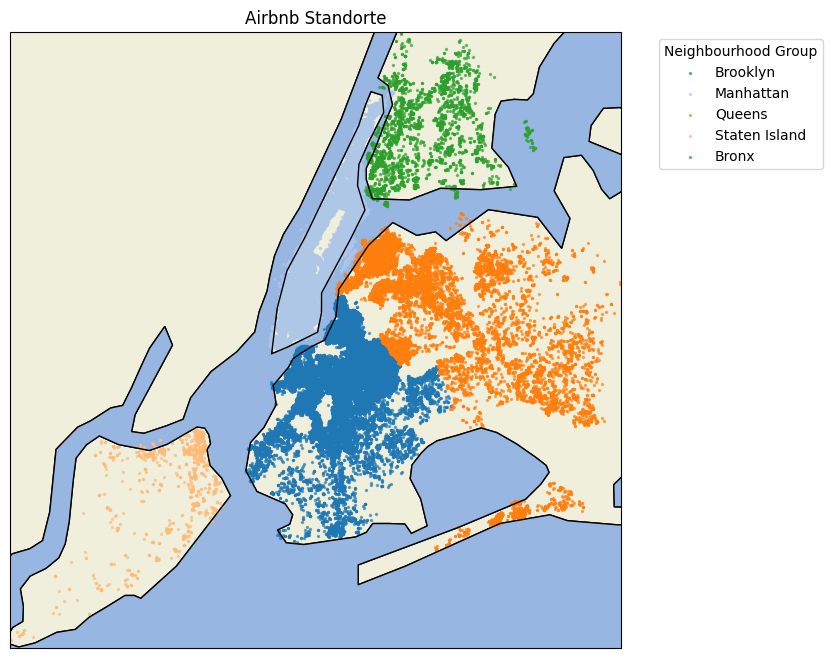

In [33]:
neighbourhood_groups = airbnb_data['neighbourhood group'].unique()
colors = plt.cm.tab20.colors
color_dict = {neighbourhood_groups[i]: colors[i % len(colors)] for i in range(len(neighbourhood_groups))}

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Mercator())

ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

buffer = 0.001
ax.set_extent([airbnb_data['long'].min() - buffer, airbnb_data['long'].max() + buffer, 
               airbnb_data['lat'].min() - buffer, airbnb_data['lat'].max() + buffer], crs=ccrs.PlateCarree())

for group in neighbourhood_groups:
    subset = airbnb_data[airbnb_data['neighbourhood group'] == group]
    plt.scatter(subset['long'], subset['lat'], color=color_dict[group], s=2, alpha=0.6, 
                label=group, transform=ccrs.PlateCarree())


plt.legend(title='Neighbourhood Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Airbnb Standorte')
plt.show()

# Statistical / Machine learning/Data Visualization method usage 

In [108]:
cluster_features = airbnb_data[['price', 'availability 365']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

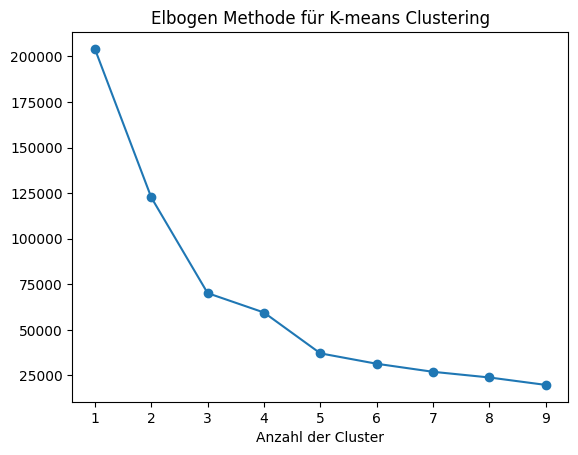

In [109]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbogen Methode für K-means Clustering')
plt.xlabel('Anzahl der Cluster')
plt.show()

In [110]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
airbnb_data['cluster'] = kmeans.fit_predict(scaled_features)

airbnb_data

,neighbourhood group,neighbourhood,lat,long,price,service fee,availability 365,cluster
0,Brooklyn,Kensington,40.64749,-73.97237,966.0,193.000000,286.0,4
1,Manhattan,Midtown,40.75362,-73.98377,142.0,28.000000,228.0,0
2,Manhattan,Harlem,40.80902,-73.94190,620.0,124.000000,352.0,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,368.0,74.000000,322.0,0
4,Manhattan,East Harlem,40.79851,-73.94399,204.0,41.000000,289.0,0
...,...,...,...,...,...,...,...,...
102053,Brooklyn,Flatbush,40.64945,-73.96108,696.0,130.155590,0.0,1
102054,Brooklyn,Bushwick,40.69872,-73.92718,909.0,126.516711,0.0,3
102055,Brooklyn,Bedford-Stuyvesant,40.67810,-73.90822,387.0,124.605310,235.0,0
102056,Manhattan,Harlem,40.81248,-73.94317,848.0,125.272811,0.0,3


In [111]:
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])

pca_df['cluster'] = airbnb_data['cluster']

pca_df

,PC1,PC2,cluster
0,-0.113832,1.568063,4
1,-1.551194,-0.512280,0
2,-1.218214,1.195350,0
3,-1.589827,0.491160,0
4,-1.756973,-0.041819,0
...,...,...,...
102053,0.895125,-0.593540,1
102054,1.349780,-0.138885,3
102055,-1.067035,0.049481,0
102056,1.219574,-0.269092,3


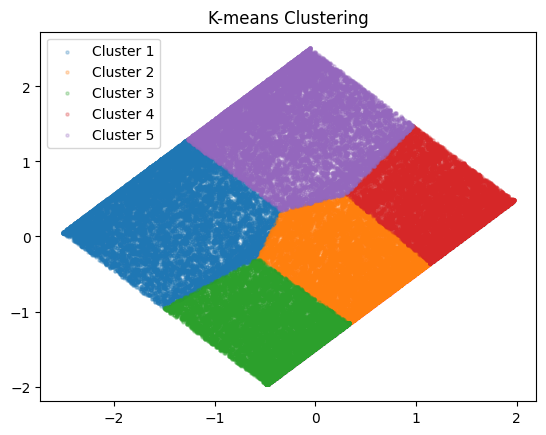

In [112]:
plt.figure()
for cluster in range(n_clusters):
    plt.scatter(pca_df[pca_df['cluster'] == cluster]['PC1'], 
                pca_df[pca_df['cluster'] == cluster]['PC2'], 
                s=5, label=f'Cluster {cluster+1}', alpha=0.25)
plt.title('K-means Clustering')
plt.legend()
plt.show()

In [113]:
cluster_analysis = airbnb_data.groupby('cluster').agg({
    'price': 'mean',
    'availability 365': 'mean',
}).reset_index()

cluster_analysis

,cluster,price,availability 365
0,0,339.455494,286.441231
1,1,621.617701,52.560143
2,2,237.148111,48.774936
3,3,1010.791159,46.081467
4,4,917.089807,285.833774


In [114]:
cluster_counts = airbnb_data['cluster'].value_counts().reset_index()
cluster_analysis = cluster_analysis.merge(cluster_counts, on='cluster', suffixes=('_x', '_y'))
cluster_analysis

,cluster,price,availability 365,count
0,0,339.455494,286.441231,18403
1,1,621.617701,52.560143,22782
2,2,237.148111,48.774936,21207
3,3,1010.791159,46.081467,21423
4,4,917.089807,285.833774,18243


In [115]:
cluster_analysis['profitability'] = cluster_analysis['price'] * (365 - cluster_analysis['availability 365']) / cluster_analysis['count']

best_clusters = cluster_analysis.sort_values(by='profitability', ascending=False)

best_clusters

,cluster,price,availability 365,count,profitability
3,3,1010.791159,46.081467,21423,15.047381
1,1,621.617701,52.560143,22782,8.525070
4,4,917.089807,285.833774,18243,3.979748
2,2,237.148111,48.774936,21207,3.536199
0,0,339.455494,286.441231,18403,1.449068


In [116]:
most_profitable_clusters = best_clusters[best_clusters['profitability'] > 10]['cluster'].tolist()
airbnb_profitability_data = airbnb_data[airbnb_data['cluster'].isin(most_profitable_clusters)]
airbnb_profitability_data

,neighbourhood group,neighbourhood,lat,long,price,service fee,availability 365,cluster
23,Brooklyn,Park Slope,40.67989,-73.97798,1050.0,210.000000,9.000000,3
25,Brooklyn,Bedford-Stuyvesant,40.68371,-73.94028,1175.0,235.000000,131.964921,3
33,Brooklyn,Greenpoint,40.72219,-73.93762,858.0,172.000000,105.865914,3
36,Brooklyn,South Slope,40.66869,-73.98780,1111.0,222.000000,112.370166,3
40,Manhattan,Lower East Side,40.71401,-73.98917,1010.0,202.000000,110.000000,3
...,...,...,...,...,...,...,...,...
102029,Queens,Astoria,40.76987,-73.92679,822.0,164.000000,0.000000,3
102031,Brooklyn,Williamsburg,40.70870,-73.96710,1078.0,216.000000,120.000000,3
102036,Brooklyn,Bedford-Stuyvesant,40.67964,-73.95629,1073.0,124.605310,0.000000,3
102054,Brooklyn,Bushwick,40.69872,-73.92718,909.0,126.516711,0.000000,3


In [117]:
unique_neighbourhoods = airbnb_data['neighbourhood'].unique()
neighbourhoods_only_in_most_profitable_clusters = []

for neighbourhood in unique_neighbourhoods:
    clusters = airbnb_data.loc[airbnb_data['neighbourhood'] == neighbourhood, 'cluster'].unique()
    if set(clusters).issubset(set(most_profitable_clusters)):
        neighbourhoods_only_in_most_profitable_clusters.append(neighbourhood)
        print(neighbourhood)
        print(clusters)

neighbourhoods_only_in_most_profitable_clusters

New Dorp
[3]
Chelsea, Staten Island
[3]


['New Dorp', 'Chelsea, Staten Island']

In [118]:
only_in_one_cluster = airbnb_data[airbnb_data['neighbourhood'].isin(neighbourhoods_only_in_most_profitable_clusters)]
only_in_one_cluster

,neighbourhood group,neighbourhood,lat,long,price,service fee,availability 365,cluster
30490,Staten Island,New Dorp,40.57044,-74.11747,1044.0,209.0,0.0,3
53137,Staten Island,"Chelsea, Staten Island",40.59116,-74.18580,1042.0,208.0,164.0,3
62175,Staten Island,New Dorp,40.57670,-74.11622,1048.0,210.0,91.0,3
73448,Staten Island,New Dorp,40.57044,-74.11747,1044.0,209.0,0.0,3
93423,Staten Island,New Dorp,40.57044,-74.11747,1044.0,209.0,0.0,3


In [119]:
neighbourhoods_in_profitable_and_one_other_cluster = []

for neighbourhood in unique_neighbourhoods:
    clusters = airbnb_data.loc[airbnb_data['neighbourhood'] == neighbourhood, 'cluster'].unique()
    clusters_set = set(clusters)
    profitable_clusters_set = set(most_profitable_clusters)
    
    # Prüfen, ob es Cluster außerhalb der profitabelsten Cluster gibt
    non_profitable_clusters = clusters_set - profitable_clusters_set
    
    # Wenn es genau ein Cluster außerhalb der profitabelsten Cluster gibt und mindestens ein profitables Cluster
    if len(non_profitable_clusters) == 1 and profitable_clusters_set.intersection(clusters_set):
        neighbourhoods_in_profitable_and_one_other_cluster.append(neighbourhood)
        print(neighbourhood)
        print(clusters)

neighbourhoods_in_profitable_and_one_other_cluster

Woodrow
[3 0]


['Woodrow']

In [127]:
in_two_cluster = airbnb_data[airbnb_data['neighbourhood'].isin(neighbourhoods_in_profitable_and_one_other_cluster)]
in_two_cluster

,neighbourhood group,neighbourhood,lat,long,price,service fee,availability 365,cluster
3050,Staten Island,Woodrow,40.53884,-74.19826,1025.0,205.0,56.0,3
52273,Staten Island,Woodrow,40.53777,-74.20674,78.0,16.0,304.0,0
71226,Staten Island,Woodrow,40.53884,-74.19826,1025.0,205.0,0.0,3


In [128]:
combined_data = pd.concat([only_in_one_cluster, in_two_cluster])

neighbourhood_stats = combined_data.groupby('neighbourhood').agg({
    'price': 'mean',
    'availability 365': 'mean',
    'lat': 'mean',
    'long': 'mean'
})

neighbourhood_counts = airbnb_data["neighbourhood"].value_counts().reset_index()
neighbourhood_analysis = neighbourhood_stats.merge(neighbourhood_counts, on='neighbourhood', suffixes=('_x', '_y'))
neighbourhood_analysis

,neighbourhood,price,availability 365,lat,long,count
0,"Chelsea, Staten Island",1042.000000,164.00,40.591160,-74.185800,1
1,New Dorp,1045.000000,22.75,40.572005,-74.117157,4
2,Woodrow,709.333333,120.00,40.538483,-74.201087,3


In [129]:
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

marker_cluster = MarkerCluster().add_to(map_clusters)

for i, row in neighbourhood_analysis.iterrows():
    profitability = row['price'] * (365-row['availability 365']) / row['count']
    profitability_rounded = round(profitability, 2)
    avg_price_rounded = round(row['price'], 2)
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Neighbourhood: {row['neighbourhood']} \n Profitability: {profitability_rounded} \n Average Price: {avg_price_rounded}"
    ).add_to(marker_cluster)

map_clusters.save('cluster_map.html')